In [18]:
import json
import pandas as pd
import numpy as np
import gcsfs
import warnings
import requests
from PIL import Image
from io import BytesIO
import random

### Prequesties

Make sure the wrapper server is running locally.

Change the endpoint below according to your setup.

In [66]:
BASE_URL = f"http://localhost:8000"
WRAPPER_API_MAP = {
    'ingest_event': f"{BASE_URL}/api/ingest/event",
    'user': f"{BASE_URL}/api/search/user_recommendations",
    'item_similarity': f"{BASE_URL}/api/search/item_similarity",
    'item_complement_topic': f"{BASE_URL}/api/search/item_complement_topic",
    'item_complement_type': f"{BASE_URL}/api/search/item_complement_type",
    'user_topics': f"{BASE_URL}/api/get_user_topics",
}

### Util function

In [3]:
def show_image_from_ulr(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    ## resize
    img = img.resize((200, 200))
    img.show()

### Data sample

In [4]:
## read data
products_df = pd.read_json("gs://ecommerce-recipe/data/source/active_products_cleaned.jsonl", lines=True)
events_df = pd.read_json("gs://ecommerce-recipe/data/source/full_events.json", lines=True, orient='records', nrows=1000)
events_df["created_at"] = pd.to_datetime(events_df["created_at"]).astype(int) // 10**9
events_df_sample = pd.merge(events_df, products_df[['id']].rename(columns={'id':'product'}), on='product')
product_id_to_url = products_df.set_index('id')['product_image'].to_dict()

In [5]:
products_df.sample(3)

,id,is_active,product_image,description,topic,brand,product_type,popularity,item_w2v
18425,18994609,1,https://media.brandalley.co.uk/catalog/product...,<ul><li>The VEJA Condor was the first ecologic...,male_shoes,veja,trainers,0.030052,"[0.1352518797, -0.0194309857, -0.1437467337000..."
21836,19060309,1,https://media.brandalley.co.uk/catalog/product...,<ul><li>The relaxed-fitting Eva cashmere jumpe...,female_clothing,boden,sweatshirts_&_fleeces,0.007409,"[0.025765787800000002, 0.0530051701, 0.0349460..."
16081,18949306,1,https://media.brandalley.co.uk/catalog/product...,<ul><li>The hard side polycarbonate is moulded...,unisex_travel,ted_baker,luggage_&_suitcases,0.181604,"[0.13755729790000001, 0.0564711913, 0.06972654..."


In [6]:
events_df_sample.head(3)

,user,session_id,product,event_type,created_at
0,2391885,1718520365363,18888360,product_viewed,1718520414
1,2097335,1724517034717,18881606,product_viewed,1724517252
2,5175921,1727358678655,18666010,product_viewed,1727358757


## Item2Item

This will be our query item we will use for the examples.

The SL weights are defined in the /config dir under wrapper and hence cannot be dynamically changed here.

You can visit the SL server notebook the experiment with the raw call to SL server where you can play with the weights.

This notebook should allow you to experiment with the custom wrapper you built on top of the SL server to handle advance logic.

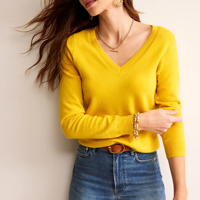

In [8]:
query_item = "19060309" ## female trouses
show_image_from_ulr(product_id_to_url[int(query_item)])

### Similarity

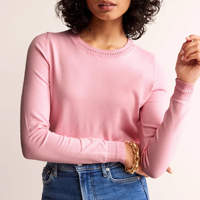

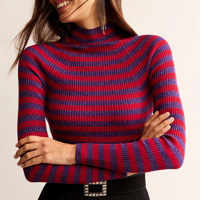

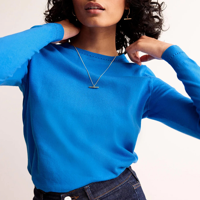

In [20]:
response = requests.get(WRAPPER_API_MAP['item_similarity'], params={'item_id': query_item, 'limit': 10})
response_json = response.json()
neighbors = [i['entity']['id'] for i in response_json]
for i in neighbors[1:4]:
    show_image_from_ulr(product_id_to_url[int(i)])

### Type complement

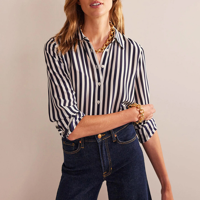

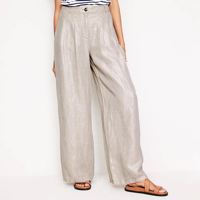

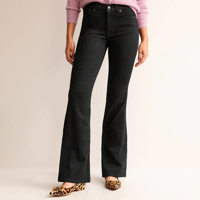

In [50]:
response = requests.get(WRAPPER_API_MAP['item_complement_type'], params={'item_id': query_item, 'limit': 10})
response_json = response.json()
neighbors = [i['entity']['id'] for i in response_json]
for i in neighbors[0:3]:
    show_image_from_ulr(product_id_to_url[int(i)])

### Topic complement

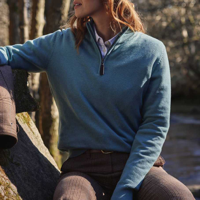

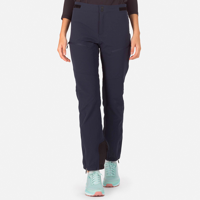

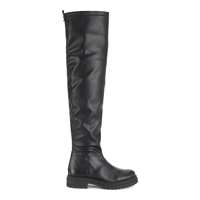

In [49]:
response = requests.get(WRAPPER_API_MAP['item_complement_topic'], params={'item_id': query_item, 'limit': 20})
response_json = response.json()
neighbors = [i['entity']['id'] for i in response_json]
random.shuffle(neighbors)
for i in neighbors[0:3]:
    show_image_from_ulr(product_id_to_url[int(i)])

## User Recommendations

First we will need to create some dummy user and ingest events for that user.

Our wrapper will handle the logic of creating multiple user vectors in SL schema for smarter averaging by topic.

In [88]:
## we will create dummpy user journey with the top 100 events from sample.
batch_events = events_df_sample.sample(100).sort_values('created_at', ascending=True)[['user', 'product', 'event_type', 'created_at']].reset_index(drop=True)
batch_events['user'] = 'test_444'
batch_events = batch_events.to_dict(orient='records')
for event in batch_events:
    response = requests.post(WRAPPER_API_MAP['ingest_event'], json=event)
    if response.status_code != 200:
        print(f"Error: {response.text}", event)

We ingested 100 events for user test_123.

Now just for debuging we can see what topic vectors we created for this user using the `get_user_topics` endpoint.

In [101]:
response = requests.get(WRAPPER_API_MAP['user_topics'], params={'user_id': 'test_444'})
print(response.json())

['male_accessories', 'unisex_beauty', 'male_clothing', 'male_shoes', 'unisex_home', 'female_clothing', 'female_accessories', 'female_shoes', 'unisex_christmas', 'female_lingerie', 'unisex_outdoor', 'unisex_clothing', 'unisex_lingerie']


Lets examine the user last 5 events to better understand the user journey and the recommendations we will generate for this user.

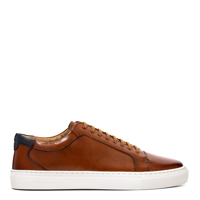

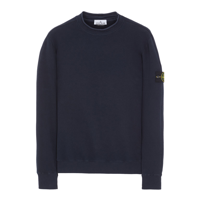

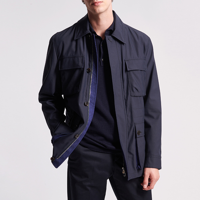

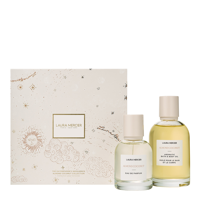

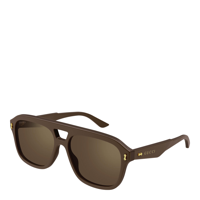

In [102]:
for event in batch_events[-5:]:
    pid = event['product']
    show_image_from_ulr(product_id_to_url[int(pid)])

Now we can proceed and query recommendations for the user easily.

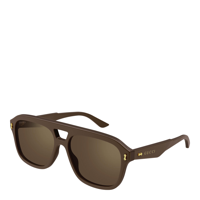

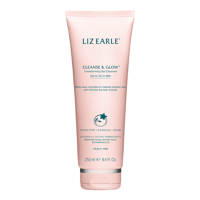

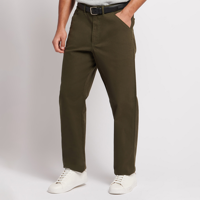

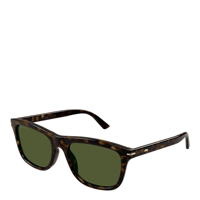

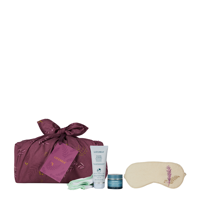

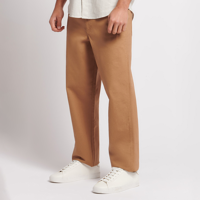

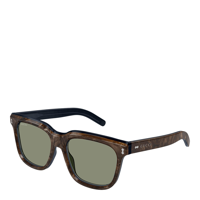

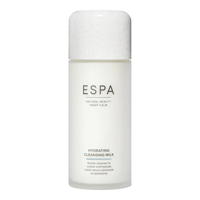

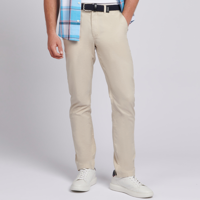

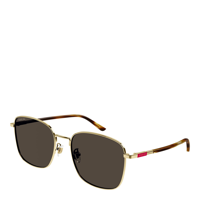

In [100]:
response = requests.get(WRAPPER_API_MAP['user'], params={'user_id': 'test_444', 'limit': 20})
response_json = response.json()
neighbors = [i['entity']['id'] for i in response_json]
for i in neighbors[:10]:
    show_image_from_ulr(product_id_to_url[int(i)])